In [1]:
cd ..

/home/dmitrii/thesis


In [20]:
from utils.kitti_api.auxiliary.laserscan import SemLaserScan

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import os
from tqdm import tqdm
import torch
import json
np.random.seed(42)

In [3]:
def permute(image):
    image = torch.Tensor(image)
    image = image.permute(2,0,1).numpy()
    return image

def mapping(labels,config):
    
    for i,label in enumerate(config['labels'].keys()):
        labels[labels == label] = i
    
    return labels

In [5]:
CONFIG = yaml.load(open("./utils/kitti_api/config/semantic-kitti.yaml"))
    
DATA_PATH = './data/kitti_dataset/raw_data/data_odometry_velodyne/dataset/sequences/'
OUT_PATH = './data/kitti_dataset/processed_data/'
TABLE_PATH = './data/split_tables/kitti/'

os.makedirs(TABLE_PATH,exist_ok=True)

#check all records
seq_list = [DATA_PATH+i for i in os.listdir(DATA_PATH) if i.find('.')==-1]


laserscan_class = SemLaserScan(nclasses=len(list(CONFIG['labels'].keys())),project=True,sem_color_dict=CONFIG['color_map'])

/home/dmitrii/anaconda3/envs/dmitrii_thesis/lib/python3.7/site-packages/ipykernel_launcher.py:1: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """Entry point for launching an IPython kernel.


In [6]:
for seq in seq_list:
    
    scans = [i[:-4] for i in os.listdir(seq+'/velodyne/') if i.find('.bin')!=-1]
    
    for scan in tqdm(scans):
        laserscan_class.open_scan(seq+'/velodyne/'+scan + '.bin')
        laserscan_class.open_label(seq+'/labels/'+scan + '.label')
        
        #get image
        image = laserscan_class.proj_xyz
        depth = laserscan_class.proj_range
        remission = laserscan_class.proj_remission
        
        #stack image
        image = permute(image)
        depth = np.expand_dims(depth,axis=0)
        remission = np.expand_dims(remission,axis=0)
        image = np.append(image,depth,axis=0)
        image = np.append(image,remission,axis=0)
        
        #get labels
        labels = laserscan_class.proj_sem_label
        labels = mapping(labels,config=CONFIG)
        labels = np.expand_dims(labels,axis=0)
        
        #get mask
        mask = laserscan_class.proj_mask
        mask = np.expand_dims(mask,axis=0)
        
        os.makedirs(OUT_PATH+seq.split('/')[-1],exist_ok=True)
        
        #save data
        np.save(OUT_PATH+seq.split('/')[-1]+f'/{scan}_scan.npy',image)
        np.save(OUT_PATH+seq.split('/')[-1]+f'/{scan}_label.npy',labels)
        np.save(OUT_PATH+seq.split('/')[-1]+f'/{scan}_mask.npy',mask)
        

100%|██████████| 271/271 [00:26<00:00, 10.07it/s]


# Prepare split tables

In [7]:
test_seq = [
    './data/kitti_dataset/processed_data/08',
     './data/kitti_dataset/processed_data/02',
     './data/kitti_dataset/processed_data/00',
     './data/kitti_dataset/processed_data/05',
    './data/kitti_dataset/processed_data/09',
     './data/kitti_dataset/processed_data/10',
]

train_UB = [
     './data/kitti_dataset/processed_data/06',
 './data/kitti_dataset/processed_data/03',
]

val_UB = [
 './data/kitti_dataset/processed_data/07',
 './data/kitti_dataset/processed_data/01',
 './data/kitti_dataset/processed_data/04'
]

In [8]:
def upload_data(seq_list: list):
    seq_arr = []
    scans = []
    for seq in seq_list:
        scans += [seq+'/'+i for i in os.listdir(seq) if i.find('scan')!=-1]
        seq_arr += [seq]*len([seq+'/'+i for i in os.listdir(seq) if i.find('scan')!=-1])

    scans = np.array(scans)
    seq_arr = np.array(seq_arr)
    return scans,seq_arr

In [9]:
#create test

records_test,_ = upload_data(test_seq)


#create test
split = {
        'test': records_test.tolist(),
    }

with open(f'{TABLE_PATH}test_split_table.json', 'w') as outfile:
        json.dump(split, outfile)

In [10]:
#create UB

train_records,_ = upload_data(train_UB)
val_records,_ = upload_data(val_UB)

split = {
        'train': train_records.tolist(),
        'val': val_records.tolist(),
        }
with open(f'{TABLE_PATH}UB_split_table.json', 'w') as outfile:
            json.dump(split, outfile)


In [11]:
train_UB

['./data/kitti_dataset/processed_data/06',
 './data/kitti_dataset/processed_data/03']

In [22]:
#create train and validation

part_data = [1,2,4] # % of each record, but validate only on 1% of each 

for part in part_data:
    
    train = []
    val = []
    for seq in train_UB:
        records,_ = upload_data([seq])
        np.random.permutation(records)
        records = records[:int(np.round(records.shape[0]*(part/100)))]
        print(f'Dataset train: {seq}, N samples: {records.shape[0]}')
        train += records.tolist()
    
    for seq in val_UB:
        records,_ = upload_data([seq])
        np.random.permutation(records)
        records = records[:int(np.round(records.shape[0]*(part/100)))]
        print(f'Dataset val: {seq}, N samples: {records.shape[0]}')
        val += records.tolist()
    
    print('\n')
    
    
    split = {
            'train': train_records.tolist(),
            'val': val_records.tolist(),
            'pretrain': records.tolist(),
        }
    with open(f'{TABLE_PATH}{part}_split_table.json', 'w') as outfile:
            json.dump(split, outfile)


Dataset train: ./data/kitti_dataset/processed_data/06, N samples: 11
Dataset train: ./data/kitti_dataset/processed_data/03, N samples: 8
Dataset val: ./data/kitti_dataset/processed_data/07, N samples: 11
Dataset val: ./data/kitti_dataset/processed_data/01, N samples: 11
Dataset val: ./data/kitti_dataset/processed_data/04, N samples: 3


Dataset train: ./data/kitti_dataset/processed_data/06, N samples: 22
Dataset train: ./data/kitti_dataset/processed_data/03, N samples: 16
Dataset val: ./data/kitti_dataset/processed_data/07, N samples: 22
Dataset val: ./data/kitti_dataset/processed_data/01, N samples: 22
Dataset val: ./data/kitti_dataset/processed_data/04, N samples: 5


Dataset train: ./data/kitti_dataset/processed_data/06, N samples: 44
Dataset train: ./data/kitti_dataset/processed_data/03, N samples: 32
Dataset val: ./data/kitti_dataset/processed_data/07, N samples: 44
Dataset val: ./data/kitti_dataset/processed_data/01, N samples: 44
Dataset val: ./data/kitti_dataset/processed_data/

# Review augs

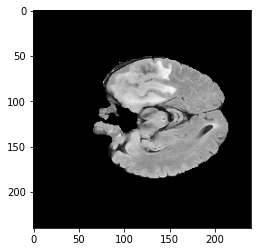

In [21]:
prob = 100
augs = A.Compose(
                [   
                    #A.HorizontalFlip(p=prob),
                    #A.VerticalFlip(p=prob),
                    #A.Rotate(limit=10, p=prob),
                    A.RandomSizedCrop(min_max_height=(90, 90), height=210, width=210, p=prob),
                    #A.ElasticTransform(alpha=0.05,sigma=12,alpha_affine=12,p=prob)
                ])
temp = np.transpose(temp.astype(np.float32), (1, 2, 0))
augmented = augs(image=temp)
temp = np.transpose(temp.astype(np.float32), (2, 0, 1))
image = augmented['image']
image = np.transpose(image.astype(np.float32), (2, 0, 1))

plt.imshow(temp[0],'gray')

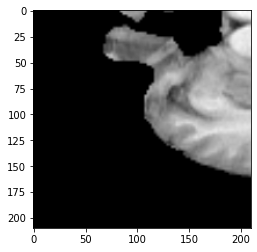

In [22]:
plt.imshow(image[1],'gray')

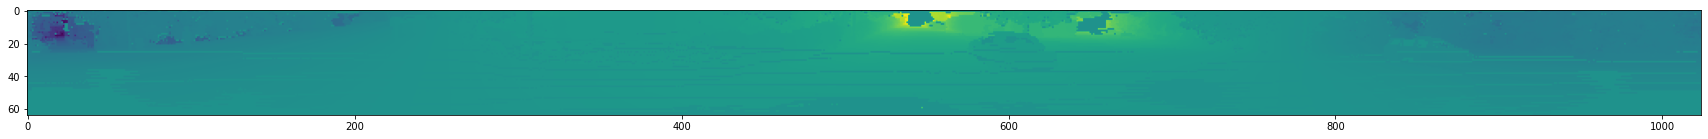

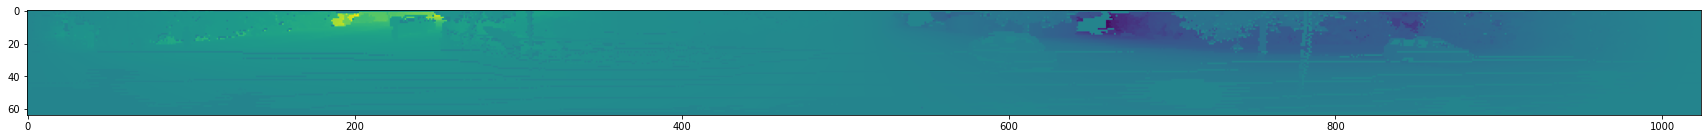

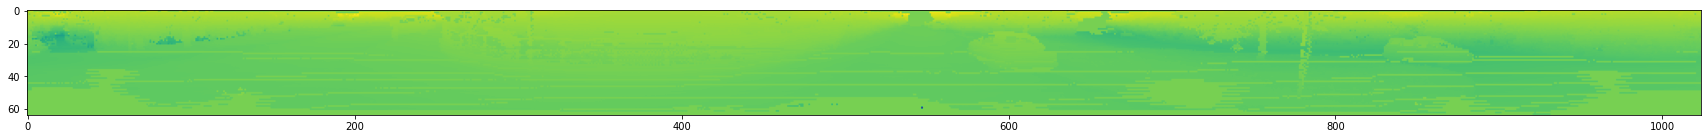

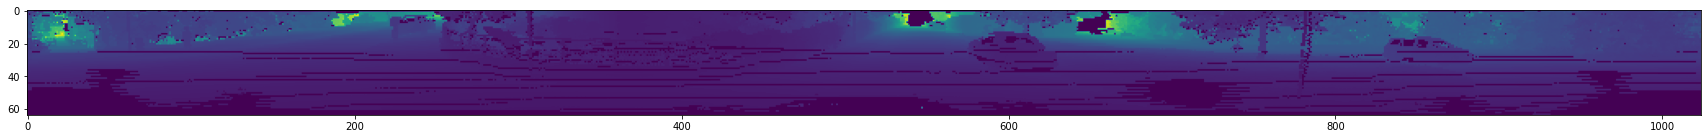

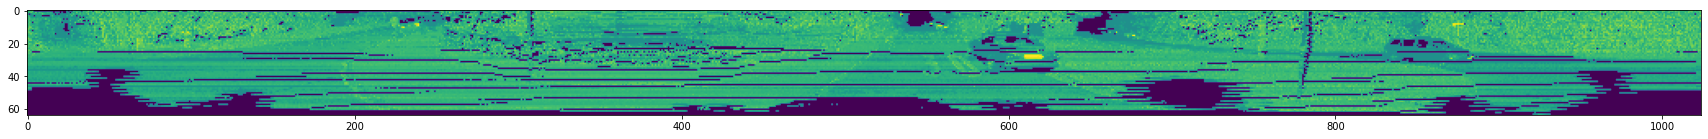

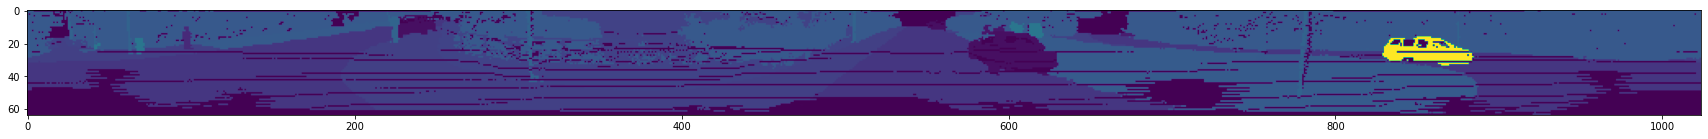

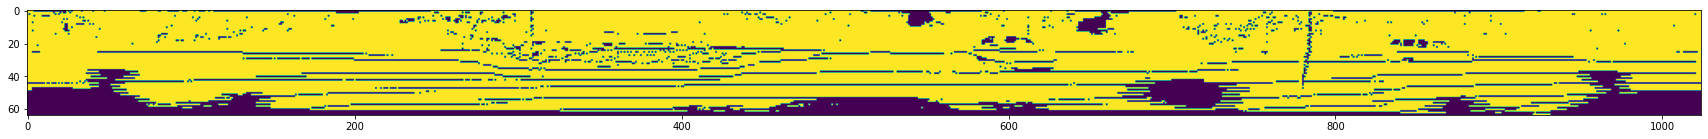

In [57]:
plt.figure(figsize=(30,10))
plt.imshow(image[0])

plt.figure(figsize=(30,10))
plt.imshow(image[1])

plt.figure(figsize=(30,10))
plt.imshow(image[2])

plt.figure(figsize=(30,10))
plt.imshow(image[3])

plt.figure(figsize=(30,10))
plt.imshow(image[4])

plt.figure(figsize=(30,10))
plt.imshow(label)

plt.figure(figsize=(30,10))
plt.imshow(mask)